Created/verified project directories: ['data', 'notebooks', 'src', 'models', 'reports']

Create and activate a clean environment, then install deps:

conda create -n ctr_env python=3.11 -y
conda activate ctr_env
pip install pandas numpy scikit-learn category-encoders lightgbm xgboost matplotlib seaborn joblib shap optuna imbalanced-learn

Loaded dataset from data/ad_10000records.csv

=== Shape ===
(10000, 10)

=== Columns & dtypes ===
Daily Time Spent on Site    float64
Age                         float64
Area Income                 float64
Daily Internet Usage        float64
Ad Topic Line                object
City                         object
Gender                       object
Country                      object
Timestamp                    object
Clicked on Ad                 int64
dtype: object

=== Missing values per column ===
Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
Ci

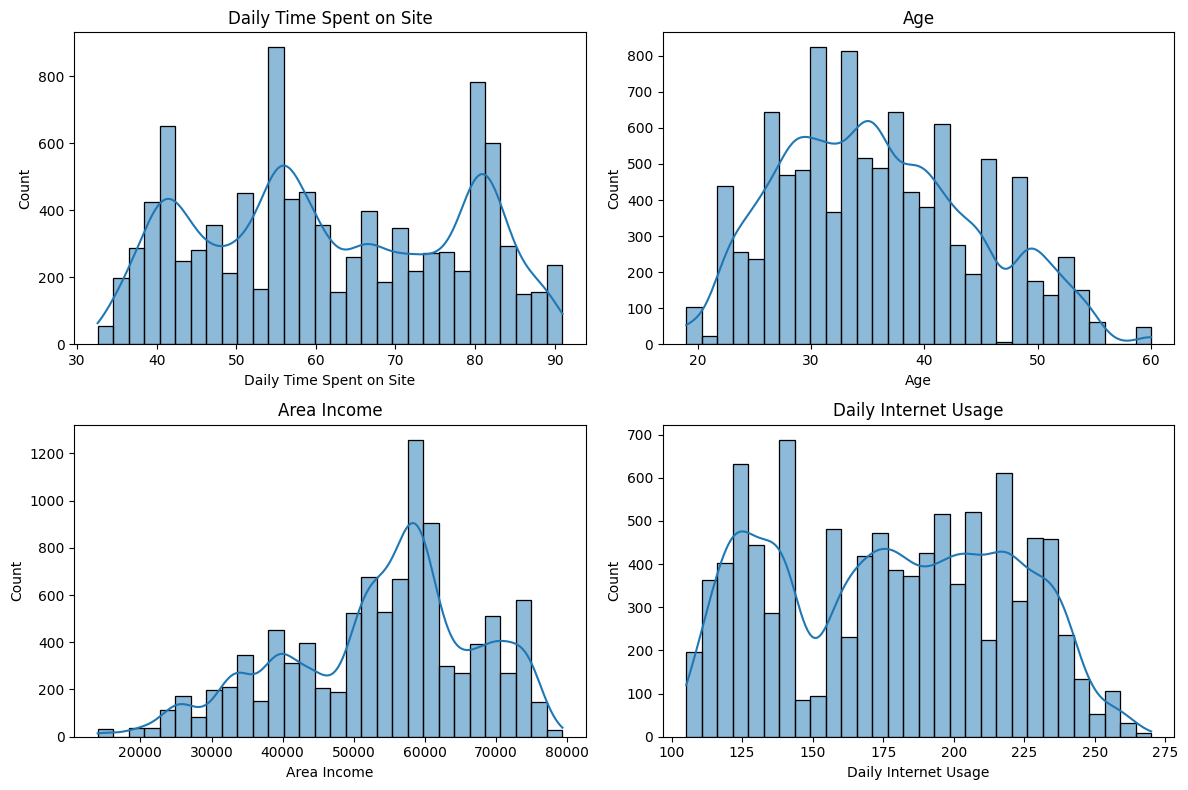


=== Correlation matrix (numeric + target) ===
Clicked on Ad               1.000000
Age                         0.460383
Daily Time Spent on Site    0.091034
Area Income                -0.067631
Daily Internet Usage       -0.129412
Name: Clicked on Ad, dtype: float64


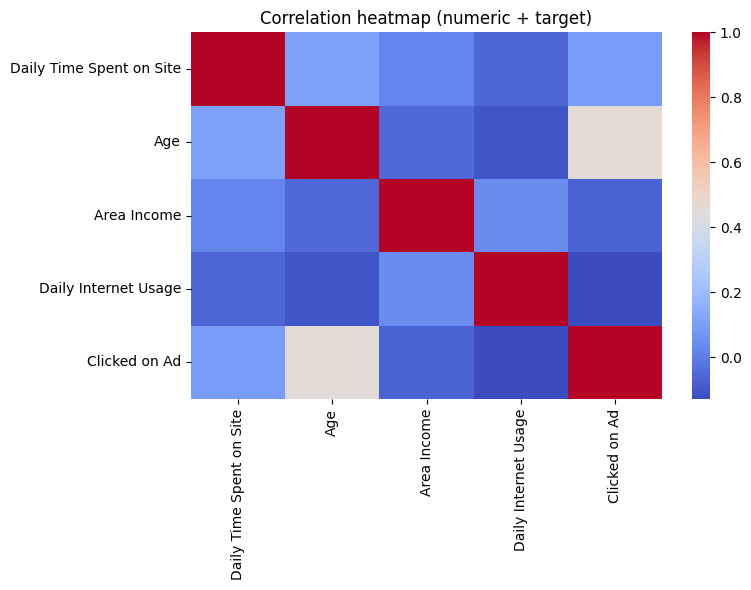


=== Timestamp parse check ===
Parsed non-null: 10000, null: 0

Top 10 hours by click rate (coarse check):
hour
12    0.710692
23    0.664835
9     0.653543
21    0.633941
8     0.612245
14    0.607744
18    0.579151
17    0.569892
11    0.549213
16    0.541315
Name: Clicked on Ad, dtype: float64

Day-of-week click rate (coarse check):
dayofweek
2    0.591615
0    0.555258
5    0.536697
3    0.520860
6    0.466111
1    0.459742
4    0.383576
Name: Clicked on Ad, dtype: float64

=== Categorical columns (object dtype) ===
['Ad Topic Line', 'City', 'Gender', 'Country', 'Timestamp']

=== Cardinality of categorical columns ===
Timestamp        567
Ad Topic Line    559
City             521
Country          207
Gender             2
dtype: int64

No highly unique columns detected at >90% uniqueness threshold.

=== EDA quick check complete. ===


In [9]:
# === Step 0: Imports ===
import os
import sys
import json
import textwrap
import pandas as pd
import numpy as np

# Optional plotting (uncomment if running in a notebook with a display)
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Set up project structure ===
PROJECT_DIRS = ["data", "notebooks", "src", "models", "reports"]

for d in PROJECT_DIRS:
    os.makedirs(d, exist_ok=True)

print("Created/verified project directories:", PROJECT_DIRS)

# Environment guidance (printed only)
env_msg = """
Create and activate a clean environment, then install deps:

conda create -n ctr_env python=3.11 -y
conda activate ctr_env
pip install pandas numpy scikit-learn category-encoders lightgbm xgboost matplotlib seaborn joblib shap optuna imbalanced-learn
"""
print(textwrap.dedent(env_msg))
# === Step 2: Paths and basic checks ===
CSV_PATH = os.path.join("data", "ad_10000records.csv")
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Expected CSV at {CSV_PATH}. Please place the dataset there.")

# === Step 3: Load CSV ===
df = pd.read_csv(CSV_PATH)
print(f"Loaded dataset from {CSV_PATH}")

# Show basic info
print("\n=== Shape ===")
print(df.shape)

print("\n=== Columns & dtypes ===")
print(df.dtypes)

# === Step 4: Missing values, duplicates ===
print("\n=== Missing values per column ===")
print(df.isna().sum().sort_values(ascending=False))

dup_count = df.duplicated().sum()
print(f"\n=== Duplicate rows ===\n{dup_count}")

# === Step 5: Target check ===
TARGET = "Clicked on Ad"
if TARGET not in df.columns:
    raise KeyError(f"Target column '{TARGET}' not found in data columns: {list(df.columns)}")

clicked_rate = df[TARGET].mean()
print(f"\n=== Target rate (mean of {TARGET}) ===")
print(clicked_rate)

print("\n=== Class balance ===")
print(df[TARGET].value_counts(dropna=False).to_frame(name="count").assign(share=lambda x: x["count"]/len(df)))

# === Step 6: Numeric columns quick stats ===
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric_cols:
    numeric_cols.remove(TARGET)

print("\n=== Numeric columns ===")
print(numeric_cols)

print("\n=== Descriptive stats (numeric) ===")
print(df[numeric_cols].describe().T)

# === Optional: Quick histograms for numeric columns ===
try:
    if len(numeric_cols) > 0:
        n = len(numeric_cols)
        ncols = 2
        nrows = int(np.ceil(n / ncols))
        plt.figure(figsize=(12, 4*nrows))
        for i, col in enumerate(numeric_cols, 1):
            plt.subplot(nrows, ncols, i)
            sns.histplot(df[col].dropna(), kde=True, bins=30)
            plt.title(col)
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"(Optional plotting skipped due to: {e})")

# === Step 7: Quick correlation check (numeric only) ===
if len(numeric_cols) >= 2:
    corr = df[numeric_cols + [TARGET]].corr(numeric_only=True)
    print("\n=== Correlation matrix (numeric + target) ===")
    print(corr[TARGET].sort_values(ascending=False))
    # Optional heatmap
    try:
        plt.figure(figsize=(8,6))
        sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f")
        plt.title("Correlation heatmap (numeric + target)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"(Optional heatmap skipped due to: {e})")

# === Step 8: Sanity checks for potential leakage ===
# 1) Timestamp parsing and simple patterns (no feature engineering yet)
time_col = "Timestamp"
if time_col in df.columns:
    try:
        ts = pd.to_datetime(df[time_col], errors="coerce")
        null_ts = ts.isna().sum()
        print(f"\n=== Timestamp parse check ===\nParsed non-null: {ts.notna().sum()}, null: {null_ts}")

        # Check hour/day-of-week correlation with target (coarse leakage signal)
        tmp = pd.DataFrame({TARGET: df[TARGET], "hour": ts.dt.hour, "dayofweek": ts.dt.dayofweek})
        hour_ctr = tmp.groupby("hour")[TARGET].mean().sort_values(ascending=False).head(10)
        dow_ctr = tmp.groupby("dayofweek")[TARGET].mean().sort_values(ascending=False)
        print("\nTop 10 hours by click rate (coarse check):")
        print(hour_ctr)
        print("\nDay-of-week click rate (coarse check):")
        print(dow_ctr)
    except Exception as e:
        print(f"(Timestamp parsing/leakage checks skipped due to: {e})")
else:
    print("\nTimestamp column not found; skipping time-based leakage checks.")

# 2) High-cardinality categorical quick glance
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
if TARGET in cat_cols:
    cat_cols.remove(TARGET)

print("\n=== Categorical columns (object dtype) ===")
print(cat_cols)

cardinality = {c: df[c].nunique(dropna=False) for c in cat_cols}
print("\n=== Cardinality of categorical columns ===")
print(pd.Series(cardinality).sort_values(ascending=False))

# Optional: very quick signal check for suspiciously perfect predictors
suspicious_cols = []
for c in df.columns:
    if c == TARGET:
        continue
    try:
        # If column uniquely identifies each row, it might be an ID-like leakage risk
        if df[c].nunique(dropna=False) > 0.9 * len(df):
            suspicious_cols.append(c)
    except Exception:
        pass

if suspicious_cols:
    print("\nWARNING: High-uniqueness columns that may risk leakage (ID-like):")
    print(suspicious_cols)
else:
    print("\nNo highly unique columns detected at >90% uniqueness threshold.")

print("\n=== EDA quick check complete. ===")


In [12]:
# === Minimal feature engineering + Stratified split ===
!pip install category_encoders
import os
import numpy as np
import pandas as pd



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import CountEncoder  # frequency encoder

# 1) Copy df to avoid side effects
data = df.copy()

TARGET = "Clicked on Ad"

# 2) Derive time features from Timestamp, then drop the raw column
if "Timestamp" in data.columns:
    data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")
    # Derive features
    data["hour"] = data["Timestamp"].dt.hour
    data["dayofweek"] = data["Timestamp"].dt.dayofweek
    data["is_weekend"] = data["dayofweek"].isin([5, 6]).astype(int)
    # Drop raw
    data = data.drop(columns=["Timestamp"])

# 3) Define column groups
numeric_cols = ["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage"]
# Keep only those that exist
numeric_cols = [c for c in numeric_cols if c in data.columns]

low_card_cat = ["Gender"]
low_card_cat = [c for c in low_card_cat if c in data.columns]

high_card_cat = ["City", "Country"]
high_card_cat = [c for c in high_card_cat if c in data.columns]

text_col = "Ad Topic Line" if "Ad Topic Line" in data.columns else None

time_derived = [c for c in ["hour", "dayofweek", "is_weekend"] if c in data.columns]

# 4) Separate features/target
X = data.drop(columns=[TARGET])
y = data[TARGET].astype(int)

# 5) Build preprocessing transformers
transformers = []

# 5a) Numeric passthrough
if numeric_cols:
    transformers.append(("num", "passthrough", numeric_cols))

# 5b) One-hot for low-card categorical (Gender)
if low_card_cat:
    transformers.append((
        "onehot_low_card",
        OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse_output=True),
        low_card_cat
    ))

# 5c) Frequency encoding for high-card categorical (City, Country)
# Use category_encoders.CountEncoder within a small pipeline wrapper so it fits in ColumnTransformer
# We’ll implement a simple passthrough pipeline around CountEncoder to keep API consistent.
from sklearn.base import BaseEstimator, TransformerMixin

class CountEncoderWrapper(BaseEstimator, TransformerMixin):
    """
    Wraps category_encoders.CountEncoder to work seamlessly inside ColumnTransformer.
    Outputs a numpy array suitable for sparse stacking (dense here by default).
    """
    def __init__(self):
        self.enc = None
        self.cols = None

    def fit(self, X_df, y=None):
        # X_df arrives as a DataFrame with only the selected columns
        self.cols = list(X_df.columns)
        self.enc = CountEncoder(normalize=True, cols=self.cols)
        self.enc.fit(X_df, y)
        return self

    def transform(self, X_df):
        X_enc = self.enc.transform(X_df)
        return X_enc.values  # return numpy array

if high_card_cat:
    transformers.append((
        "freq_high_card",
        CountEncoderWrapper(),
        high_card_cat
    ))

# 5d) TF-IDF on Ad Topic Line
if text_col is not None:
    transformers.append((
        "tfidf_text",
        TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=3,
            max_features=5000,
            lowercase=True
        ),
        text_col
    ))

# 5e) Time-derived passthrough
if time_derived:
    transformers.append(("time", "passthrough", time_derived))

# 6) ColumnTransformer
# Note: when using TfidfVectorizer on a single text column with ColumnTransformer, set the remainder to 'drop' and ensure text column is specified by name.
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=0.3  # allow sparse where beneficial
)

# 7) Create a preprocessing-only pipeline (no model yet)
preprocess_pipeline = Pipeline(steps=[
    ("pre", preprocessor)
])

# 8) Perform stratified 70/15/15 split on the target
# First: train (70%) vs temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Then: split temp into validation (15%) and test (15%)
# Since temp is 30% of the data, to get 15% each, we split temp 50/50.
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# 9) Fit the preprocessing on train only and transform all splits (optional now, or defer to model pipeline)
# You can fit/transform now to verify shapes; in practice, keep preprocessing inside a final model pipeline.
preprocess_pipeline.fit(X_train, y_train)

X_train_t = preprocess_pipeline.transform(X_train)
X_valid_t = preprocess_pipeline.transform(X_valid)
X_test_t  = preprocess_pipeline.transform(X_test)

# 10) Print split sizes and shapes for confirmation
print("Stratified splits (70/15/15):")
print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")
print("Transformed feature matrices:")
try:
    # If sparse, these have .shape directly; if mixed, handled by ColumnTransformer
    print(f"X_train_t shape: {X_train_t.shape}")
    print(f"X_valid_t shape: {X_valid_t.shape}")
    print(f"X_test_t  shape: {X_test_t.shape}")
except Exception as e:
    print(f"Could not determine shapes of transformed data: {e}")

# 11) Optional: quick check of class balance after split
def _balance_info(name, y_series):
    return f"{name} size={len(y_series)}, pos={y_series.sum()}, pos_rate={y_series.mean():.4f}"

print(_balance_info("Train", y_train))
print(_balance_info("Valid", y_valid))
print(_balance_info("Test",  y_test))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00
Stratified splits (70/15/15):
Train: (7000, 11), Valid: (1500, 11), Test: (1500, 11)
Transformed feature matrices:
X_train_t shape: (7000, 1092)
X_valid_t shape: (1500, 1092)
X_test_t  shape: (1500, 1092)
Train size=7000, pos=3442, pos_rate=0.4917
Valid size=1500, pos=738, pos_rate=0.4920
Test size=1500, pos=737, pos_rate=0.4913


In [14]:
# === Pipeline v1: Logistic Regression with specified preprocessing ===
import os
import json
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure output folders exist
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)

# If you don't already have these column groups handy, reconstruct them from X_train
all_cols = X_train.columns.tolist()

numeric_cols = [c for c in ["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage"] if c in all_cols]
low_card_cat = [c for c in ["Gender"] if c in all_cols]
high_card_cat = [c for c in ["City", "Country"] if c in all_cols]
text_col = "Ad Topic Line" if "Ad Topic Line" in all_cols else None
time_derived = [c for c in ["hour", "dayofweek", "is_weekend"] if c in all_cols]

# Wrapper for CountEncoder to use inside ColumnTransformer
class CountEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.enc = None
        self.cols = None

    def fit(self, X_df, y=None):
        self.cols = list(X_df.columns)
        self.enc = CountEncoder(normalize=True, cols=self.cols)
        self.enc.fit(X_df, y)
        return self

    def transform(self, X_df):
        return self.enc.transform(X_df).values

# Build the ColumnTransformer matching your spec
transformers = []
if numeric_cols:
    # StandardScaler for numeric
    transformers.append(("num", StandardScaler(), numeric_cols))

if low_card_cat:
    transformers.append((
        "onehot_low_card",
        OneHotEncoder(drop="if_binary", handle_unknown="ignore", sparse_output=True),
        low_card_cat
    ))

if high_card_cat:
    transformers.append((
        "freq_high_card",
        CountEncoderWrapper(),
        high_card_cat
    ))

if text_col is not None:
    transformers.append((
        "tfidf_text",
        TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=3,
            max_features=5000,
            lowercase=True
        ),
        text_col
    ))

if time_derived:
    transformers.append(("time", "passthrough", time_derived))

preprocessor_lr = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=0.3  # allow sparse when beneficial
)

# Base Logistic Regression model as specified
base_lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="liblinear"  # works well with sparse inputs; you can also try 'saga'
)

# Toggle calibration if well-calibrated probabilities are required
calibrate = False  # set True to enable calibration

if not calibrate:
    clf = Pipeline(steps=[
        ("pre", preprocessor_lr),
        ("model", base_lr)
    ])
else:
    # Wrap LR with CalibratedClassifierCV; calibration performed on validation fold(s)
    # We'll fit on train only; calibration uses internal CV on the training data
    calibrated_model = CalibratedClassifierCV(
        estimator=base_lr,
        method="isotonic",  # or "sigmoid" (Platt)
        cv=5
    )
    clf = Pipeline(steps=[
        ("pre", preprocessor_lr),
        ("model", calibrated_model)
    ])

# Fit on training split
clf.fit(X_train, y_train)

# Evaluate on validation split
y_valid_proba = clf.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

metrics = {
    "roc_auc": float(roc_auc_score(y_valid, y_valid_proba)),
    "pr_auc": float(average_precision_score(y_valid, y_valid_proba)),
    "accuracy": float(accuracy_score(y_valid, y_valid_pred)),
    "precision": float(precision_score(y_valid, y_valid_pred, zero_division=0)),
    "recall": float(recall_score(y_valid, y_valid_pred, zero_division=0)),
    "f1": float(f1_score(y_valid, y_valid_pred, zero_division=0)),
    "calibrated": bool(calibrate),
    "threshold": 0.5
}

print("Validation metrics (LR v1):")
for k, v in metrics.items():
    print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")

# Save metrics
with open(os.path.join("reports", "metrics_lr_v1.json"), "w") as f:
    json.dump(metrics, f, indent=2)

# Persist the fitted pipeline
from joblib import dump
model_path = os.path.join("models", "ctr_lr_v1.joblib")
dump(clf, model_path)
print(f"Saved pipeline to: {model_path}")


Validation metrics (LR v1):
roc_auc: 0.890011
pr_auc: 0.883357
accuracy: 0.788000
precision: 0.796610
recall: 0.764228
f1: 0.780083
calibrated: False
threshold: 0.500000
Saved pipeline to: models/ctr_lr_v1.joblib
